In [1]:
!pip install gdown==4.6.0
# !pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [3]:
import os
import gdown
import zipfile
import pickle
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization,Activation,Reshape,LSTM
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import pickle

# from PIL._imaging import display
from tensorflow import keras
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from torchvision.io import read_image
from torchvision.io import read_image
import torchvision
from PIL import Image
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
import torch


### Download the dataset from google drive (Optional if you do not have the dataset)

In [4]:
# https://drive.google.com/file/d/1YysOEXW-OjCwfS0tXu87ANtuHjPfDkJ1/view?usp=share_link
# Collected the id from drive link
# 1YysOEXW-OjCwfS0tXu87ANtuHjPfDkJ1
# !gdown --id 1YysOEXW-OjCwfS0tXu87ANtuHjPfDkJ1
# !pip install --upgrade --no-cache-dir gdown
!gdown --no-cookies https://drive.google.com/uc?id=1dcO2Hyery3NbwPGRs11wlGnv6LIyhsUC
# !gdown https://drive.google.com/file/d/1dcO2Hyery3NbwPGRs11wlGnv6LIyhsUC/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1dcO2Hyery3NbwPGRs11wlGnv6LIyhsUC
To: /content/dataset.zip
100% 417M/417M [00:09<00:00, 46.2MB/s]


In [5]:
data_zip=zipfile.ZipFile('dataset.zip')
data_zip.extractall()
data_zip.close()

# Pre-Processing

In [6]:
# Creating the "model" folder for saving the "Best Model"
if not (os.path.exists('model')):
    os.mkdir('model')

In [ ]:
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    full_result = [merge(constants, ob) for ob in object_params]
    return full_result

In [ ]:
def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)

    return params

In [ ]:
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [ ]:
def balance(xdf_data):
    """
    xdf_data: dataframe for both x & y
    """
    # Augmenting Minority Target Variabe

    # The RandomOverSampler
    ros = RandomOverSampler(random_state=55)
    x = xdf_data.iloc[:, :-1]
    y = xdf_data.iloc[:, -1]

    # Augment the training data
    X_ros_train, y_ros_train = ros.fit_resample(x, y)
    new_data = pd.DataFrame(data=X_ros_train, columns=xdf_data.columns[:-1])
    new_data['name'] = y_ros_train
    return new_data

In [ ]:
def crop_img(image_path, x_min, y_min, x_max, y_max):
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [ ]:
def extract_faces(image_name, image_info, input_data_path):
    faces = []
    df_one_img = image_info[image_info['file'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'name']]
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num]
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label, f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [ ]:
def save_image(image, image_name, output_data_path, dataset_type, label):
    output_path = os.path.join(output_data_path, dataset_type, label, f'{image_name}.png')
    image.save(output_path)

In [ ]:
def preprocessing():
    input_data_path = str(os.getcwd()) + '/images'
    annotations_path = str(os.getcwd()) + "/annotations"
    images = [*os.listdir(str(os.getcwd()) + "/images")]
    output_data_path = '.'
    dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path + "/*.xml")]

    full_dataset = sum(dataset, [])

    df = pd.DataFrame(full_dataset)
    print(df.shape)

    print(df.head())

    final_test_image = 'maksssksksss0'
    df_final_test = df.loc[df["file"] == final_test_image]
    images.remove(f'{final_test_image}.png')
    df = df.loc[df["file"] != final_test_image]

    print(df["name"].value_counts())

    # joined masked incorrectly with without mask
    df['name'] = df['name'].replace('mask_weared_incorrect', 'without_mask')

    df.insert(9, 'label', df.name)
    df = df.drop(['name'], axis=1)
    df = balance(df)
    labels = df['name'].unique()
    directory = ['train', 'test', 'val']
    output_data_path = '.'
    for label in labels:
        for d in directory:
            path = os.path.join(output_data_path, d, label)
            if not os.path.exists(path):
                os.makedirs(path)
    cropped_faces = [extract_faces(img, df, input_data_path) for img in images]
    flat_cropped_faces = sum(cropped_faces, [])
    with_mask = [(img, image_name) for img, label, image_name in flat_cropped_faces if label == "with_mask"]

    mask_weared_incorrect = [(img, image_name) for img, label, image_name in flat_cropped_faces if
                             label == "mask_weared_incorrect"]
    without_mask = [(img, image_name) for img, label, image_name in flat_cropped_faces if label == "without_mask"]

    print(len(with_mask))
    print(len(without_mask))
    print(len(mask_weared_incorrect))
    print(len(with_mask) + len(without_mask) + len(mask_weared_incorrect))

    train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
    test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)
    train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
    test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)
    for image, image_name in train_with_mask:
        save_image(image, image_name, output_data_path, 'train', 'with_mask')

    for image, image_name in train_without_mask:
        save_image(image, image_name, output_data_path, 'train', 'without_mask')

    for image, image_name in test_with_mask:
        save_image(image, image_name, output_data_path, 'test', 'with_mask')

    for image, image_name in test_without_mask:
        save_image(image, image_name, output_data_path, 'test', 'without_mask')

    for image, image_name in val_with_mask:
        save_image(image, image_name, output_data_path, 'val', 'with_mask')

    for image, image_name in val_without_mask:
        save_image(image, image_name, output_data_path, 'val', 'without_mask')

In [ ]:
preprocessing()

(4072, 9)
              file  width  height  depth       name  xmin  ymin  xmax  ymax
0  maksssksksss436    300     400      3  with_mask    79   174   126   226
1  maksssksksss436    300     400      3  with_mask   206   120   259   178
2   maksssksksss66    380     400      3  with_mask   179    81   267   173
3  maksssksksss103    400     300      3  with_mask    42    54    94   110
4  maksssksksss103    400     300      3  with_mask   188    46   236   106
with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: name, dtype: int64
3231
3231
0
6462


# Train

In [ ]:
def masked_model():
    model = Sequential()

    model.add(Conv2D(128, kernel_size=5,strides=1,padding='same',input_shape=(35, 35, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=3, strides=2, padding='same'))

    model.add(Conv2D(72,kernel_size=3,strides=1,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=5, strides=4, padding='same'))

    model.add(Conv2D(64,kernel_size=3,strides=1,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=5, strides=4, padding='same'))

    model.add(Conv2D(64,kernel_size=3,strides=1,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=4, strides=4, padding='same'))

    model.add(Reshape((-1, 64)))
    # LSTM
    model.add(LSTM(32))
    model.add(Dense(units=1, activation='sigmoid'))
    #
    model.summary()
    return model

In [ ]:
# Data Augmentation for train images
def create_datagen():
    return ImageDataGenerator(
        rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
        height_shift_range=0.1, rotation_range=4, vertical_flip=False
    )

In [ ]:
# Data Augmentation for validation and test images
def create_valDatagen():
    return ImageDataGenerator(
        rescale=1.0 / 255
    )

In [ ]:
def create_dataset_generator(datagen, batch_size, path,shuffle):
    return datagen.flow_from_directory(
        directory=str(os.getcwd()) + path,
        target_size=(35, 35),
        class_mode="binary", batch_size=batch_size, shuffle=shuffle

    )

In [ ]:
def train():
    batch_size = 8
    epochs = 100
    model = masked_model()
    datagen = create_datagen()
    val_datagen = create_valDatagen()
    train_generator = create_dataset_generator(datagen, batch_size, '/train',True)
    # Validation data
    val_generator = create_dataset_generator(val_datagen, batch_size, '/val',True)
    test_generator = create_dataset_generator(val_datagen, batch_size, '/test',False)

    data_size = len(train_generator)
    steps_per_epoch = int(data_size / batch_size)
    print(f"steps_per_epoch: {steps_per_epoch}")
    val_steps = int(len(val_generator) // batch_size)
    print(f"val_steps: {val_steps}")
    # opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer='RMSprop',
        loss="binary_crossentropy",
        metrics=['accuracy', 'Recall', 'Precision']
    )
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    lrr = ReduceLROnPlateau(monitor='val_loss', patience=8, verbose=1, factor=0.5, min_lr=0.00001)
    model_history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        shuffle=True,
        verbose=1,
        validation_data=val_generator,
        validation_steps=val_steps,

        callbacks=[early_stopping, lrr]
    )
    model_loss, model_acc, recall, precision= model.evaluate(test_generator)
    print("Test Scores:")
    print(
        f'Loss: {model_loss:.3f} || Accuracy: {model_acc * 100:.3f} || Recall: {recall * 100:.3f} || Precision: {precision * 100:.3f}')
    model.save_weights("model/masked_detection_model.h5")
    with open('model/history', 'wb') as file_pi:
        pickle.dump(model_history.history, file_pi)

In [ ]:
# Uncomment this part if you want to train the model
train()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 128)       9728      
                                                                 
 batch_normalization (BatchN  (None, 35, 35, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 35, 35, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 72)        83016     
                                                                 
 batch_normalization_1 (Batc  (None, 18, 18, 72)       2

# Test

In [ ]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel='epoch number', ylabel='loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel='epoch number', ylabel='accuracy')
    plt.show()

In [ ]:
def evaluation(y, y_hat, title='Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    sns.heatmap(cm, cmap='PuBu', annot=True, fmt='g', annot_kws={'size': 20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)

    plt.show()

In [ ]:
def prediction_label(predicts):
    temp = []
    for i in predicts:
        if i[0] < 0.5:
            temp.append(0)
        else:
            temp.append(1)
    return temp

In [ ]:
def test():
    batch_size = 8
    model = masked_model()
    model.load_weights('model/masked_detection_model.h5')
    with open('model/history', "rb") as file_pi:
        model_history = pickle.load(file_pi)
    val_datagen = create_valDatagen()
    test_generator = create_dataset_generator(val_datagen, batch_size, '/test',False)
    predictions = model.predict(test_generator)
    y_pred = prediction_label(predictions)
    y_pred = np.array(y_pred)
#     plot_loss_and_accuracy(model_history)
    y_true = test_generator.labels
    print(np.bincount(y_pred))
    model.compile(
        optimizer='RMSprop',
        loss="binary_crossentropy",
        metrics=['accuracy', 'Recall', 'Precision']
    )
    model_loss, model_acc, recall, precision= model.evaluate(test_generator)
    F1 = 2 * (precision * recall) / (precision + recall)
    print(f"F1 Score - {F1:.4f}")
#     print(classification_report(y_true, y_pred))
#     evaluation(y_true, y_pred)
    return model,model_history,y_true,y_pred,test_generator

In [ ]:
model,model_history,y_true,y_pred,test_generator=test()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 35, 35, 128)       9728      
                                                                 
 batch_normalization_4 (Batc  (None, 35, 35, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 35, 35, 128)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 18, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 18, 72)        83016     
                                                                 
 batch_normalization_5 (Batc  (None, 18, 18, 72)      

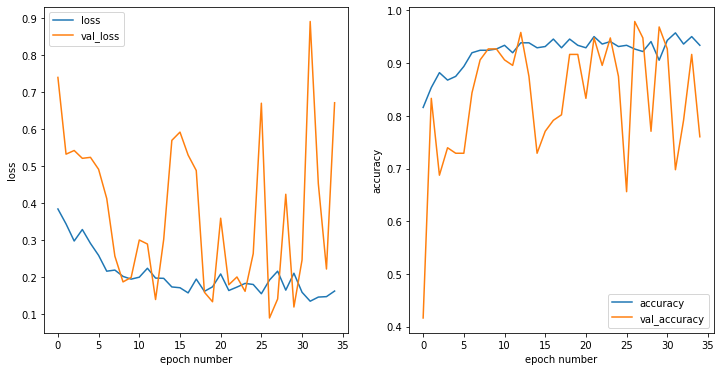

In [ ]:
plot_loss_and_accuracy(model_history)

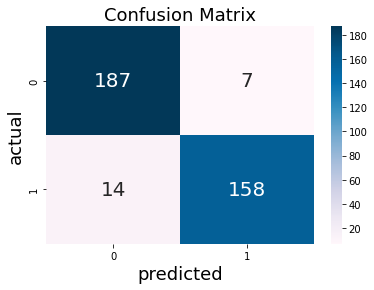

In [ ]:
evaluation(y_true, y_pred)

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       194
           1       0.96      0.92      0.94       172

    accuracy                           0.94       366
   macro avg       0.94      0.94      0.94       366
weighted avg       0.94      0.94      0.94       366



# Test with new images 

In [ ]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(35, 35))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor
new_image = load_image('withoutmask.jpg')
predictions = model.predict(new_image)
if predictions[0][0]<0.5:
    print("With Mask")
else:
    print("With Out Mask")


# Bouding Box

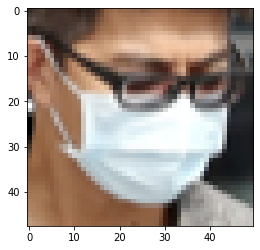

In [ ]:
# randomly selects a image from the test set
paths = test_generator.filenames
a_img_rand = np.random.randint(0, len(paths))
img = cv2.imread(os.path.join('', 'test', paths[a_img_rand]))
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(colored_img)

In [ ]:
classes = test_generator.class_indices
# true_label = paths[a_img_rand].split('/')[0]
true_label = paths[a_img_rand]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'{predicted_label} || {true_label}')

with_mask || with_mask/maksssksksss316_(91, 38).png


In [ ]:
true_label

'with_mask/maksssksksss316_(91, 38).png'

In [ ]:
# Let's Create the label and original image and bbox value
true_label=true_label.split('/')
true_class=true_label[0]
true_label

['with_mask', 'maksssksksss316_(91, 38).png']

In [ ]:
originalimageinfo=true_label[1].split('_')
originalimageinfo

['maksssksksss316', '(91, 38).png']

In [ ]:
originalimagename="images/"+originalimageinfo[0]+".png"
originalimageAnnotations="annotations/"+originalimageinfo[0]+".xml"

In [ ]:
originalimageinfo[1]=originalimageinfo[1].replace('.png','')
originalimageinfo[1]=originalimageinfo[1].replace(')','')
originalimageinfo[1]=originalimageinfo[1].replace('(','')
bbboxdimension=originalimageinfo[1].split(',')
bbboxdimension

['91', ' 38']

In [ ]:
# Read the annotation file for bounding box
box=[]
from xml.dom import minidom
file = minidom.parse(originalimageAnnotations)
bndbox = file.getElementsByTagName('bndbox')
for elem in bndbox:
    xmin=elem.getElementsByTagName('xmin')
    ymin=elem.getElementsByTagName('ymin')
    xmax=elem.getElementsByTagName('xmax')
    ymax=elem.getElementsByTagName('ymax')
    bbboxdimension[1]=bbboxdimension[1].replace(" ","")
    if xmin[0].firstChild.nodeValue==bbboxdimension[0] and  ymin[0].firstChild.nodeValue==bbboxdimension[1]:
        box.append(int(xmin[0].firstChild.nodeValue))
        box.append(int(ymin[0].firstChild.nodeValue))
        box.append(int(xmax[0].firstChild.nodeValue))
        box.append(int(ymax[0].firstChild.nodeValue))
        
    
print(box)

[91, 38, 133, 78]


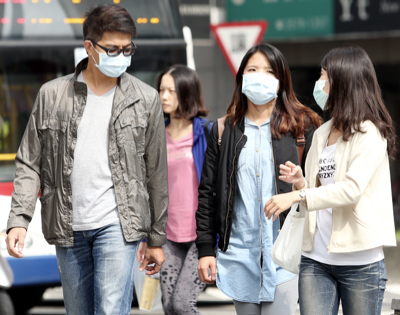

In [ ]:
img_original = Image.open(originalimagename)
img_predicted = Image.open(originalimagename)
img_original = img_predicted.convert('RGB')
img_predicted = img_predicted.convert('RGB')
img_original

In [ ]:
transform = transforms.PILToTensor()
img_original=transform(img_original)
img_predicted=transform(img_predicted)

In [ ]:
# The format for boxes is list inside the list so we will make another list and append our box
# boxes=[[63,138,93,171]]
boxes=[]
boxes.append(box)
boxes=torch.tensor(boxes,dtype=torch.int)

### Original Image Classification

In [ ]:
original_label=[]
original_label.append(true_class)
img=draw_bounding_boxes(img_original, boxes, width=3, colors=(0,255,0),labels=original_label,font_size=4)
img = torchvision.transforms.ToPILImage()(img)

/usr/local/lib/python3.8/dist-packages/torchvision/utils.py:232: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


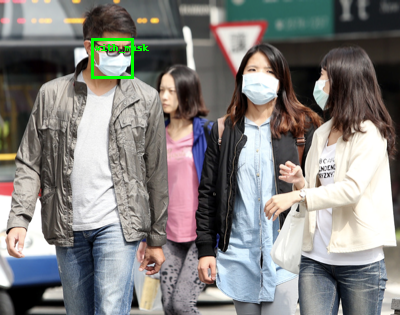

In [ ]:
img

### Predicated Image Classification

In [ ]:
predicted_labels=[]
predicted_labels.append(predicted_label)
img=draw_bounding_boxes(img_predicted, boxes, width=3, colors=(0,255,0),labels=predicted_labels,font_size=4)
img = torchvision.transforms.ToPILImage()(img)

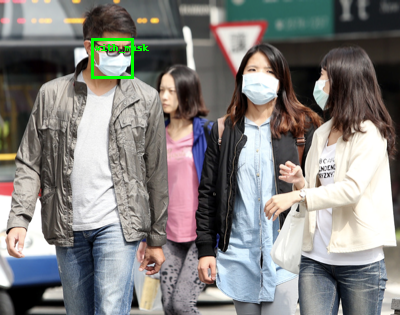

In [ ]:
img